# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

_Additional Reference_: MCMC Tutorial - https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html

### Student Information

_Full Name (Last Name, First Name)_: MA. EZTHELIA KAYE B. CAMIT \
_Student No._:09666717713\
_Section_:THY-TX1

### Submission Information

_Date and Time Submitted (most recent upload)_:

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name:MA. EZTHELIA KAYE B. CAMIT**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

import emcee
import corner


In [8]:
# Read LIGO dataset
LIGO_data = pd.read_csv(r"C:/Users/Slim 3/Desktop/AP157/LIGO.csv")
zLIGO = LIGO_data['zLIGO']
dLLIGO = LIGO_data['dlLIGO']
errLIGO = LIGO_data['errLIGO']

# Read LISA dataset
LISA_data = pd.read_csv(r"C:/Users/Slim 3/Desktop/AP157/LISA.csv")
zLISA = LISA_data['zLISA']
dLLISA = LISA_data['dlLISA']
errLISA = LISA_data['errLISA']

# Read ET dataset
ET_data = pd.read_csv(r"C:/Users/Slim 3/Desktop/AP157/ET.csv")
zET = ET_data['zET']
dLET = ET_data['dlET']
errET = ET_data['errET']

By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

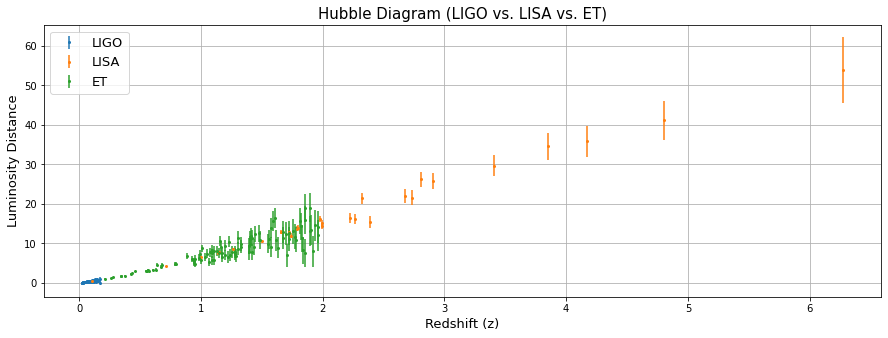

In [13]:
plt.figure(figsize=(15, 5)) # setting figure dimensions

plt.errorbar(zLIGO, dLLIGO, yerr=errLIGO, fmt='o', markersize=2, label='LIGO') # errorbar plot for LIGO
plt.errorbar(zLISA, dLLISA, yerr=errLISA, fmt='o', markersize=2, label='LISA') # errorbar plot for LISA
plt.errorbar(zET, dLET, yerr=errET, fmt='o', markersize=2, label='ET') # errorbar plot for ET

plt.title('Hubble Diagram (LIGO vs. LISA vs. ET)', fontsize=15) # other plotting operations
plt.xlabel('Redshift (z)', fontsize=13)
plt.ylabel('Luminosity Distance', fontsize=13)
plt.legend(fontsize=13)
plt.grid()

As observed in the plot we can see that the redshift and luminosity distance are linearly related. Which means that as the luminosity increases the redshift value also increases, and vice versa.

#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [39]:
from astropy.cosmology import FlatLambdaCDM

In [40]:
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dLLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0)or (Om0 > 1):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

# LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dLLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0)or (Om0 > 1):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))

# the code that i put on this lower half is based on the provided code
# LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zET)/1000)
    dev = (model - np.array(dLET))/np.array(errET)
    chi2 = sum(dev**2)
    return chi2


def llikeLIGOLISAET_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0) + chi2ET_lcdm(H0, Om0))

In [41]:
def lnprob_LIGO(x): #
    H0, Om0 = x
    return llikeLIGO_lcdm(H0, Om0)

def lnprob_LIGOLISA(x):
    H0, Om0 = x
    return llikeLIGOLISA_lcdm(H0, Om0)

def lnprob_LIGOLISAET(x):
    H0, Om0 = x
    return llikeLIGOLISAET_lcdm(H0, Om0)

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can try the ff. parameters-- number of walkers (nwalkers) of 100 and number of iterations (niter) of 1,000 and number of burn-in samples (nburn) of 100.

Note that the number of dimensions (ndim) is the number of parameters, equal to 2.

For the methodology of stepping from one place of the grid to another, you can use:

    dres = [0.1, 0.003] # step size for H_0 and omega_m,0, respectively
    initial = np.array([70., 0.3])
    p0 = [initial + dres * np.random.randn(ndim) for i in range(nwalkers)]

For the 'lnprob' function equivalent, you can define (for example):

    def lnprob(x):
      '''params: H0, Om0 = x0, x1'''
      return llikeLIGOLISA_lcdm(x[0], x[1])

Also note that because in our definition of likelihood functions, the data is ``hard-coded'', you do not need to use the "args" keyword in the emcee.EnsembleSampler command.

In [45]:
nwalkers = 100
niter = 1000
nburn = 100
ndim = 2

dres = [0.1, 0.003]
initial = np.array([70., 0.3])
p0 = [initial + dres * np.random.randn(ndim) for i in range(nwalkers)]

sampler_ligo = emcee.EnsembleSampler(nwalkers, ndim, lnprob_LIGO)
sampler_ligo.run_mcmc(p0, niter, progress=True)
samples_ligo = sampler_ligo.get_chain(discard=nburn,thin=2,flat=True) ## we had to flatten this because there where issues with having same dimensions

100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


In [46]:
sampler_ligolisa = emcee.EnsembleSampler(nwalkers, ndim, lnprob_LIGOLISA)
sampler_ligolisa.run_mcmc(p0, niter, progress=True)
samples_ligolisa = sampler_ligolisa.get_chain(discard=nburn,thin=2,flat=True)

100%|██████████| 1000/1000 [08:27<00:00,  1.97it/s]


In [47]:
sampler_ligolisaet = emcee.EnsembleSampler(nwalkers, ndim, lnprob_LIGOLISAET)
sampler_ligolisaet.run_mcmc(p0, niter, progress=True)
samples_ligolisaet = sampler_ligolisaet.get_chain(discard=nburn,thin=2,flat=True)

100%|██████████| 1000/1000 [21:12<00:00,  1.27s/it]


#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.

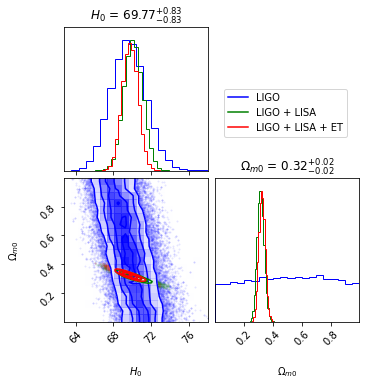

In [49]:
labels = [r'$H_{0}$', '$\Omega_{m0}$']

fig_1 = corner.corner(samples_ligo,
              labels=labels,
              color='blue',
              show_titles=True)
fig_2 = corner.corner(samples_ligolisa,
              labels=labels,
              fig=fig_1,
              color='green',
              show_titles=True)
fig_3 = corner.corner(samples_ligolisaet,
              labels=labels,
              fig=fig_2,
              color='red',
              show_titles=True)

blue_line = mlines.Line2D([], [], color='blue', label='LIGO')
green_line = mlines.Line2D([], [], color='green', label='LIGO + LISA')
red_line = mlines.Line2D([], [], color='red', label='LIGO + LISA + ET')

plt.legend(handles=[blue_line, green_line, red_line], bbox_to_anchor=(0.95, 1.25), loc=4)
plt.show()


Based on the subplots we can understand what this weird values indicate. Actually the $H_0$ is the hubble constant while $\Omega_{m0}$ is an approximation of how much matter is the universe made of. Looking at the first subplot (top left), we can say that LIGO, LISA, and ET are good at approximating the hubble constant. Moving forward to the other subplots, looking at the 2nd subplot (lower left) we can see that the LIGO values are not that good in geeting how much matter the universe is made of ($\Omega_{m0}$). To visualise it betterr we can try to look at the last subplot(lower right subplot). As we can see the graph of LIGO is almost like a straight line, which indicates that it wasnt able to quantify how much matter the universe is made of. The almost straight line plot means that there's an equal chance that the universe is made of 0% or 100% matter.